In [1]:
# Setup: Zugriff auf Vorlesungsdateien im Unterordner "Lectures"
import sys
import numpy as np
import scipy
import matplotlib.pyplot as plt
import networkx as nx

# Lokalen Modulpfad ergänzen
sys.path.append("./Lectures")

# Eigene Klassen
from hierarchical_planner import HierarchicalPlanner
from benchmark_runner import BenchmarkRunner
from evaluation_utils import summarize_results, plot_benchmark_results
from testEnvironments import TestEnvironments

# Planer und Umgebung aus Vorlesung
from IPVisibilityPRM import VisPRM
from IPBasicPRM import BasicPRM
from IPEnvironment import CollisionChecker


Text to explain something

$ x^2+5=0 $


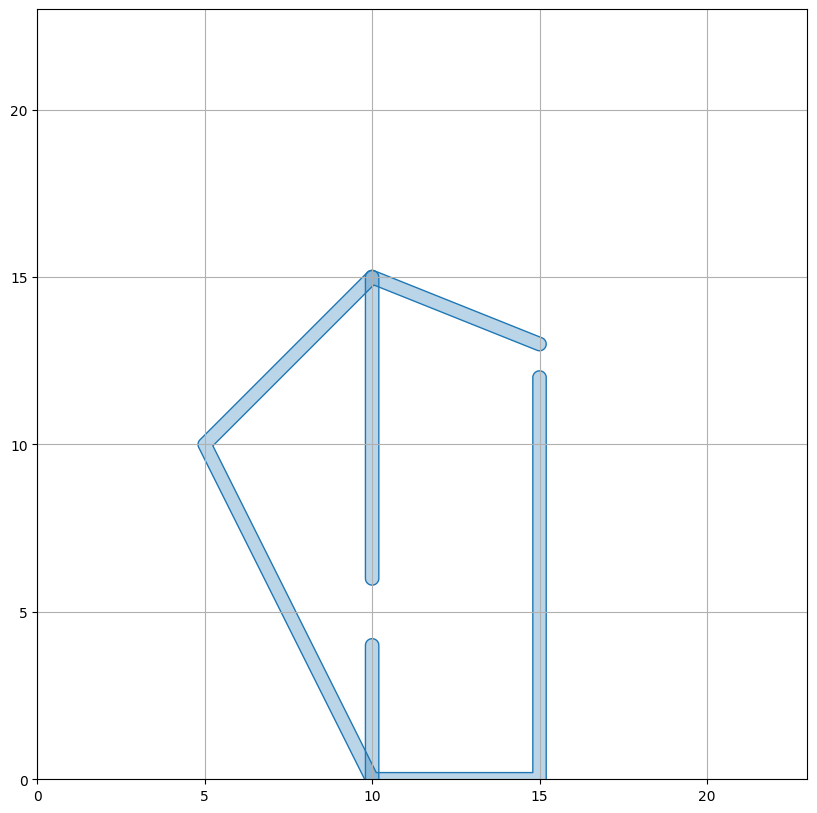

In [2]:
import matplotlib.pyplot as plt

from shapely.geometry import Point, Polygon, LineString
from shapely import plotting

MedField1 = dict()
MedField1["obs1"] = LineString([(15,13), (10,15), (5,10), (10,0), (15,0), (15,12) ]).buffer(0.2)
MedField1["obs2"] = LineString([(10,0), (10,4) ]).buffer(0.2)
MedField1["obs3"] = LineString([(10,15), (10,6) ]).buffer(0.2)

def drawScene(content, limits=[[0,23],[0,23]], figsize=(10,10)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1,1,1)
    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    for key, value in content.items():
        plotting.plot_polygon(value, add_points=False)
        

drawScene(MedField1, figsize=(10,10))


----------- Benchmark Results -----------
Number of nodes: 162
Number of edges: 1003
Collision checks performed: 847
Path found with length: 90.41
Planning time: 0.13 seconds
------------------------------------------


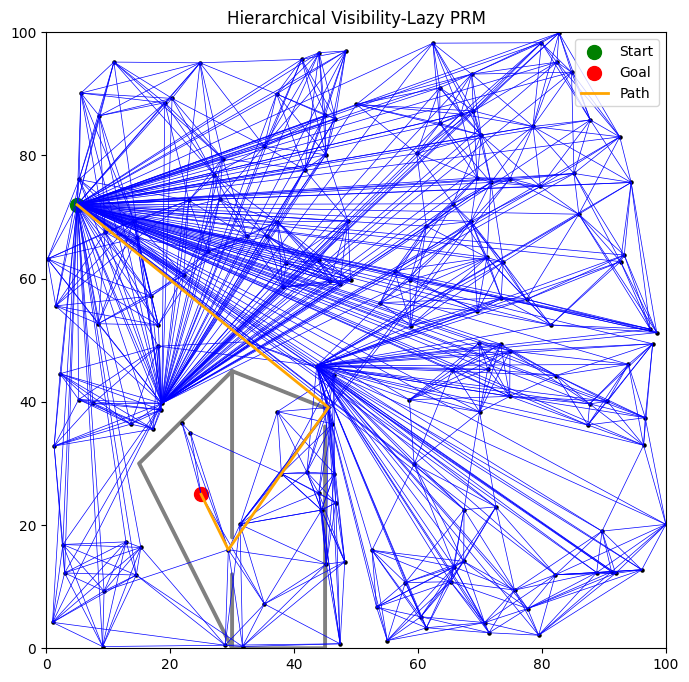

In [3]:
import networkx as nx
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from shapely.geometry import Point, Polygon, LineString


# ---------- CONFIGURATION ----------
map_bounds = (0, 100, 0, 100)

obstacles = [
    LineString([(45, 39), (30, 45), (15, 30), (30, 0), (45, 0), (45, 36)]).buffer(0.2),
    LineString([(30, 0), (30, 12)]).buffer(0.2),
    LineString([(30, 45), (30, 18)]).buffer(0.2)
]

num_regions = 4
samples_per_region = 40
lazy_k_neighbors = 8


# ---------- COLLISION COUNTER ----------
collision_checks = 0


def is_collision(p1, p2, obstacles):
    """Check if the line between p1 and p2 collides with any obstacle."""
    global collision_checks
    collision_checks += 1

    line = LineString([p1, p2])
    for obs in obstacles:
        if line.crosses(obs) or line.within(obs):
            return True
    return False


def sample_free(bounds, obstacles):
    """Sample a collision-free point."""
    minx, maxx, miny, maxy = bounds
    while True:
        x = random.uniform(minx, maxx)
        y = random.uniform(miny, maxy)
        point = Point(x, y)
        if not any(obs.contains(point) for obs in obstacles):
            return (x, y)


# ---------- LAZY PRM ----------
def build_lazy_prm(region_bounds, num_samples, k, obstacles):
    G = nx.Graph()
    nodes = []

    for _ in range(num_samples):
        node = sample_free(region_bounds, obstacles)
        G.add_node(node)
        nodes.append(node)

    for node in nodes:
        distances = [(other, np.linalg.norm(np.subtract(node, other)))
                     for other in nodes if other != node]
        distances.sort(key=lambda x: x[1])
        neighbors = distances[:k]

        for neighbor, dist in neighbors:
            G.add_edge(node, neighbor, weight=dist)

    return G


# ---------- VISIBILITY PRM ----------
def build_visibility_prm(nodes, obstacles):
    G = nx.Graph()
    for node in nodes:
        G.add_node(node)

        for other in G.nodes:
            if other == node:
                continue

            try:
                _ = nx.shortest_path(G, source=node, target=other)
                continue
            except nx.NetworkXNoPath:
                pass

            if not is_collision(node, other, obstacles):
                dist = np.linalg.norm(np.subtract(node, other))
                G.add_edge(node, other, weight=dist)

    return G


# ---------- HIERARCHICAL PRM ----------
def build_hierarchical_visibility_lazy_prm(global_bounds, num_regions, samples_per_region, k, obstacles):
    minx, maxx, miny, maxy = global_bounds
    midx = (minx + maxx) / 2
    midy = (miny + maxy) / 2

    regions = [
        (minx, midx, miny, midy),  # Bottom-left
        (midx, maxx, miny, midy),  # Bottom-right
        (minx, midx, midy, maxy),  # Top-left
        (midx, maxx, midy, maxy)   # Top-right
    ]

    local_graphs = []
    all_nodes = []

    for region in regions:
        local_graph = build_lazy_prm(region, samples_per_region, k, obstacles)
        local_graphs.append(local_graph)
        all_nodes.extend(local_graph.nodes)

    global_graph = build_visibility_prm(all_nodes, obstacles)

    for local in local_graphs:
        global_graph.add_edges_from(local.edges(data=True))

    return global_graph


# ---------- LAZY VALIDATION ----------
def validate_lazy_path(G, path, obstacles):
    valid = True
    for u, v in zip(path[:-1], path[1:]):
        if is_collision(u, v, obstacles):
            G.remove_edge(u, v)
            valid = False
    return valid


def lazy_shortest_path(G, start, goal, obstacles):
    while True:
        try:
            path = nx.shortest_path(G, source=start, target=goal, weight='weight')
        except nx.NetworkXNoPath:
            return None

        if validate_lazy_path(G, path, obstacles):
            return path


# ---------- PLOTTING ----------
def plot_prm(G, obstacles, start=None, goal=None, path=None):
    plt.figure(figsize=(8, 8))

    # Plot obstacles
    for obs in obstacles:
        x, y = obs.exterior.xy
        plt.fill(x, y, color='gray')

    # Plot edges
    for (u, v) in G.edges:
        x = [u[0], v[0]]
        y = [u[1], v[1]]
        plt.plot(x, y, color='blue', linewidth=0.5)

    # Plot nodes
    xs, ys = zip(*G.nodes)
    plt.scatter(xs, ys, color='black', s=5)

    # Plot start and goal
    if start:
        plt.scatter(start[0], start[1], color='green', s=100, label="Start")
    if goal:
        plt.scatter(goal[0], goal[1], color='red', s=100, label="Goal")

    # Plot path
    if path:
        px, py = zip(*path)
        plt.plot(px, py, color='orange', linewidth=2, label="Path")

    plt.xlim(map_bounds[0], map_bounds[1])
    plt.ylim(map_bounds[2], map_bounds[3])
    plt.legend()
    plt.title("Hierarchical Visibility-Lazy PRM")
    plt.show()


# ---------- MAIN ----------
if __name__ == "__main__":
    start_time = time.time()

    collision_checks = 0  # Reset

    # Build graph
    G = build_hierarchical_visibility_lazy_prm(map_bounds, num_regions, samples_per_region, lazy_k_neighbors, obstacles)

    start = (5, 72)
    goal = (25, 25)

    G.add_node(start)
    G.add_node(goal)

    for node in G.nodes:
        if node == start or node == goal:
            continue
        if not is_collision(node, start, obstacles):
            dist = np.linalg.norm(np.subtract(node, start))
            G.add_edge(node, start, weight=dist)
        if not is_collision(node, goal, obstacles):
            dist = np.linalg.norm(np.subtract(node, goal))
            G.add_edge(node, goal, weight=dist)

    # Lazy search
    path = lazy_shortest_path(G, start, goal, obstacles)

    end_time = time.time()
    planning_time = end_time - start_time

    # Compute path length
    path_length = 0
    if path:
        for u, v in zip(path[:-1], path[1:]):
            path_length += np.linalg.norm(np.subtract(u, v))

    # ---------- BENCHMARK ----------
    print("\n----------- Benchmark Results -----------")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Collision checks performed: {collision_checks}")
    if path:
        print(f"Path found with length: {path_length:.2f}")
    else:
        print("No valid path found.")
    print(f"Planning time: {planning_time:.2f} seconds")
    print("------------------------------------------")

    # ---------- PLOT ----------
    plot_prm(G, obstacles, start, goal, path)


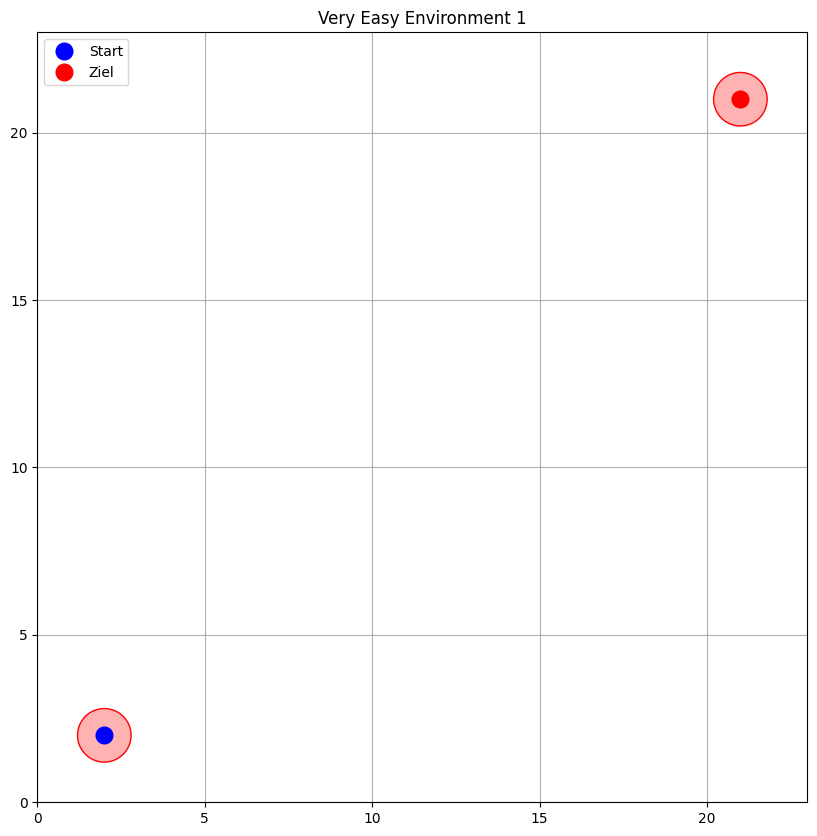

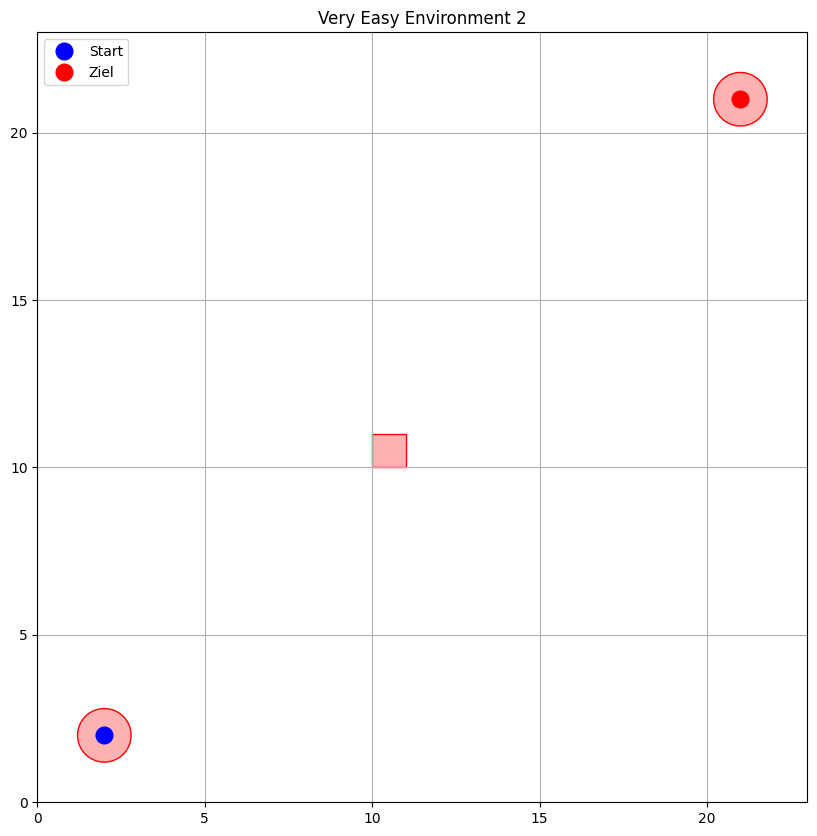

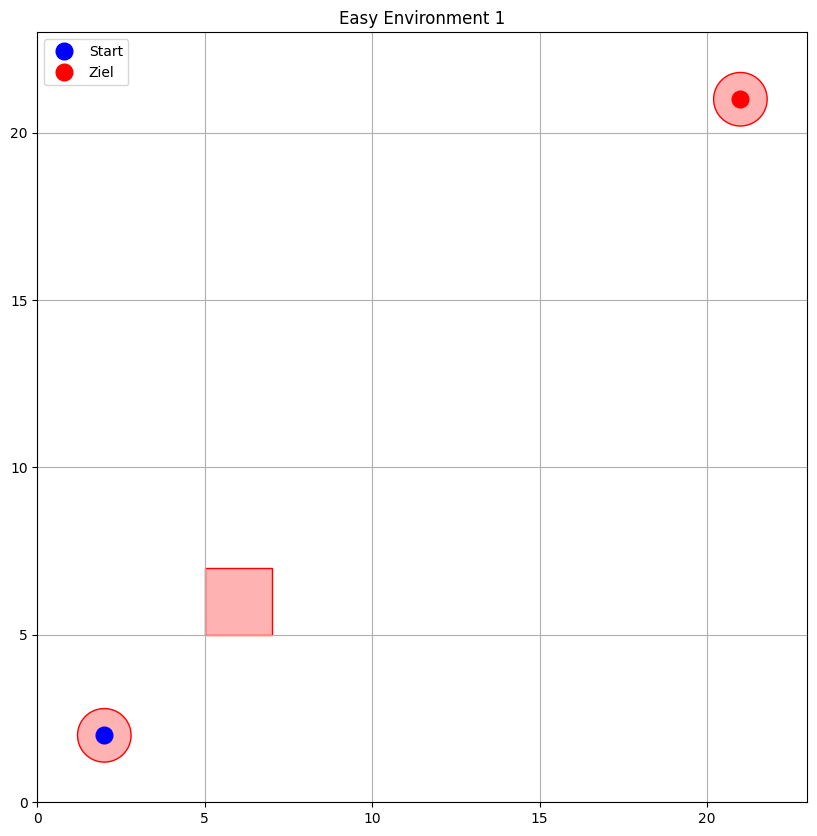

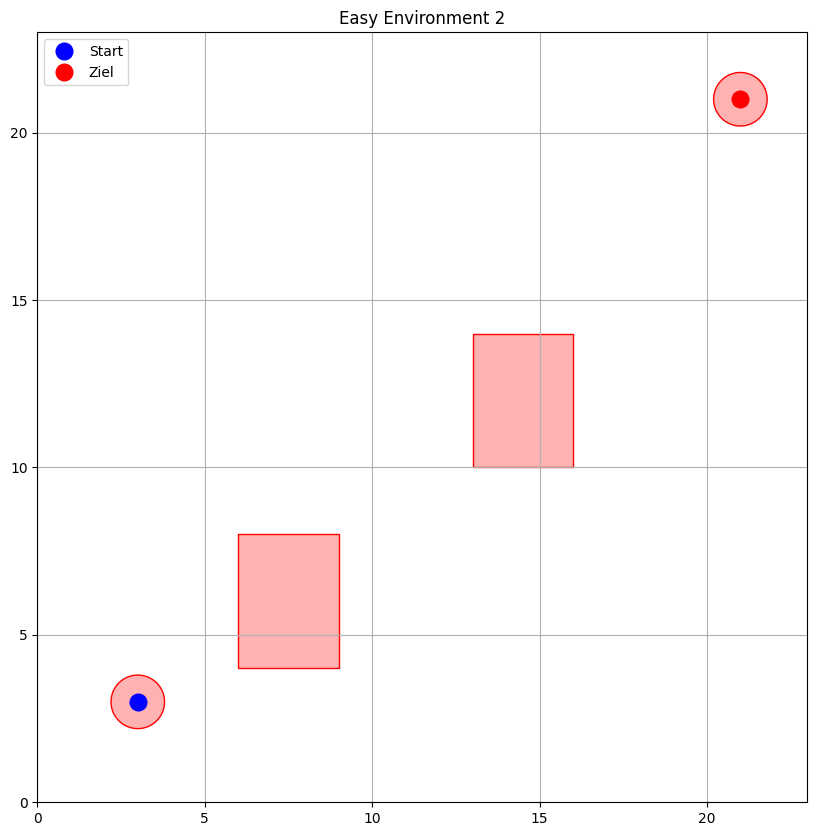

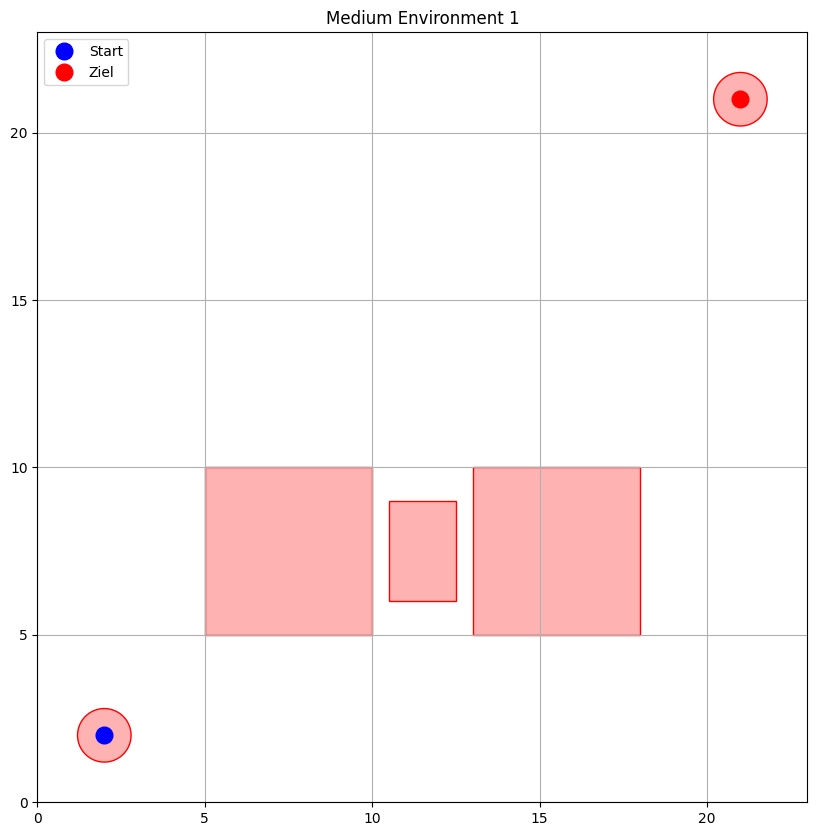

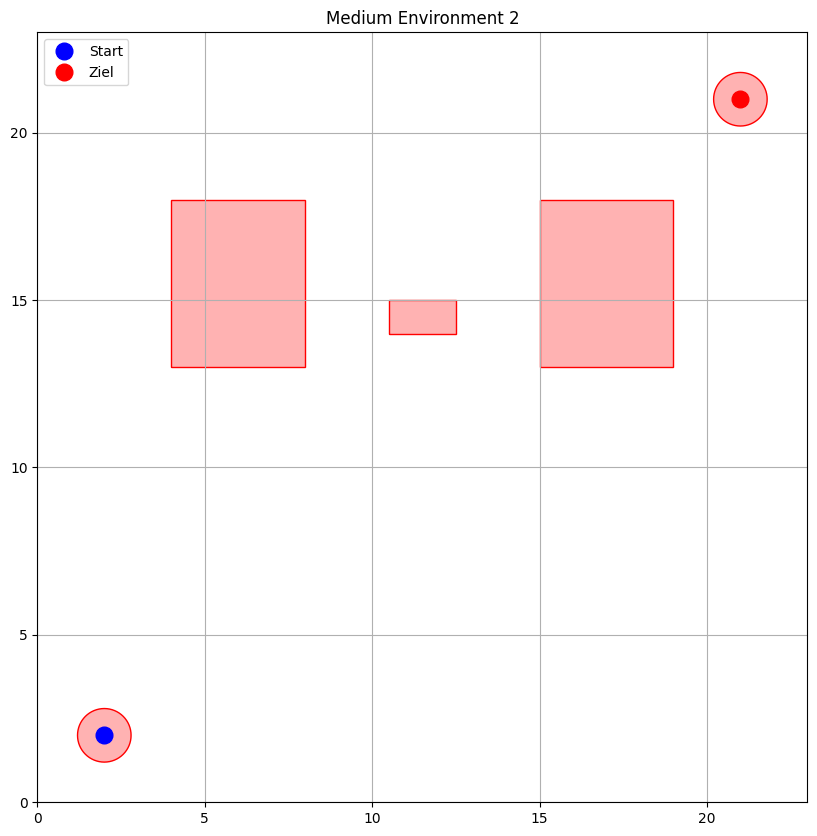

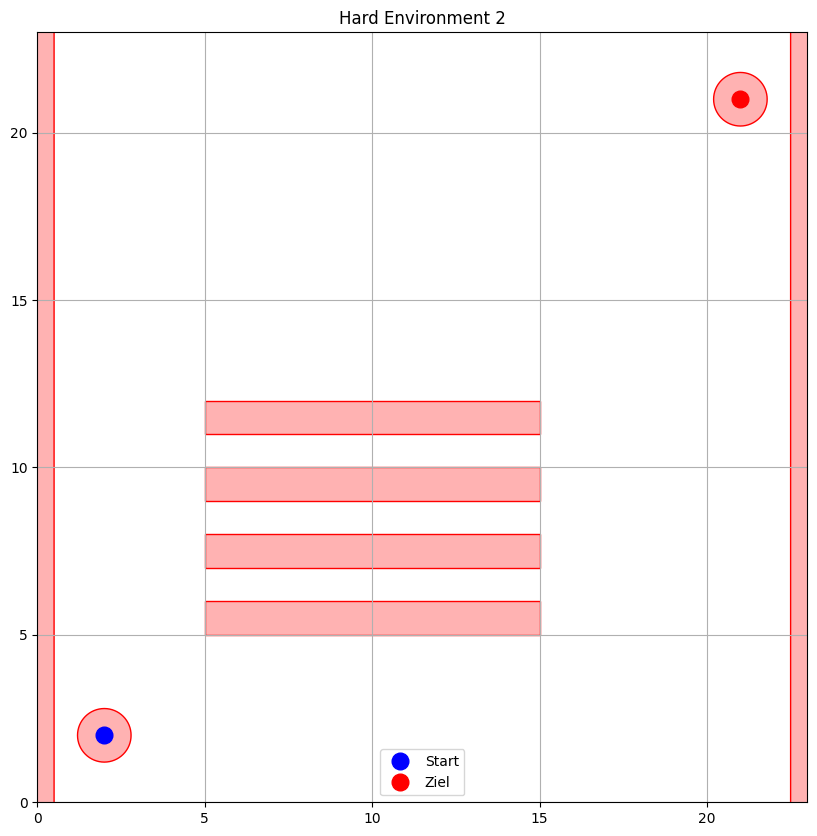

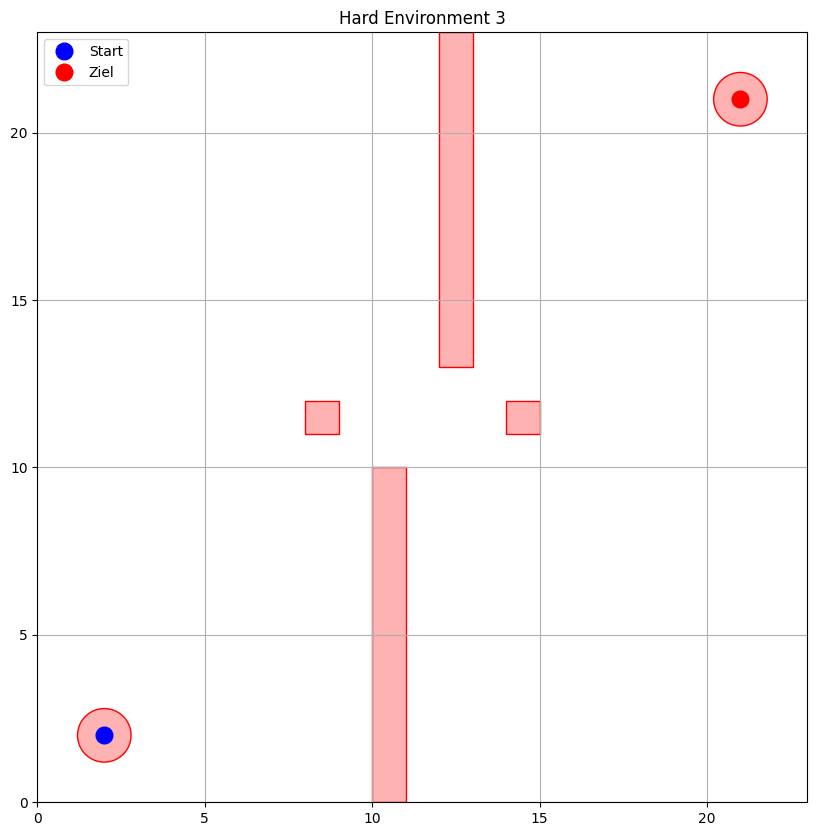

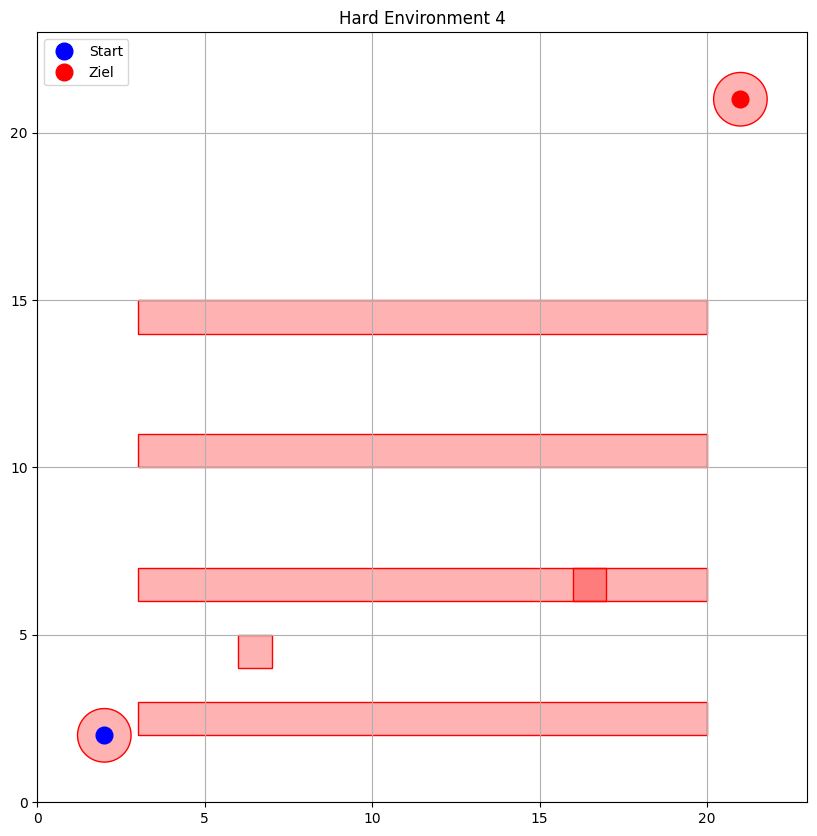

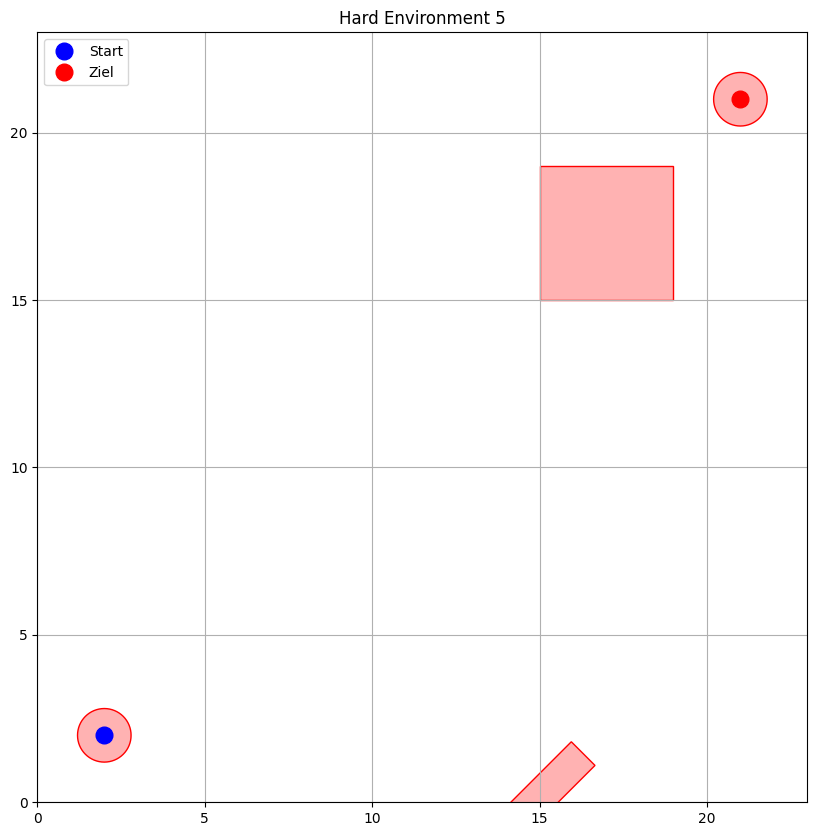

In [4]:
envs = TestEnvironments()

# Lade Umgebungen
very_easy_env1 = envs.get_very_easy_1()
very_easy_env2 = envs.get_very_easy_2()
easy_env1 = envs.get_easy_1()
easy_env2 = envs.get_easy_2()
medium_env1 = envs.get_medium_1()
medium_env2 = envs.get_medium_2()
hard_env2 = envs.get_hard_2()
hard_env3 = envs.get_hard_3()
hard_env4 = envs.get_very_hard_1()
hard_env5 = envs.get_very_hard_2()

# Zeichne mit Titeln
envs.draw_scene(very_easy_env1, title="Very Easy Environment 1")
envs.draw_scene(very_easy_env2, title="Very Easy Environment 2")
envs.draw_scene(easy_env1, title="Easy Environment 1")
envs.draw_scene(easy_env2, title="Easy Environment 2")
envs.draw_scene(medium_env1, title="Medium Environment 1")
envs.draw_scene(medium_env2, title="Medium Environment 2")
envs.draw_scene(hard_env2, title="Hard Environment 2")
envs.draw_scene(hard_env3, title="Hard Environment 3")
envs.draw_scene(hard_env4, title="Hard Environment 4")
envs.draw_scene(hard_env5, title="Hard Environment 5")


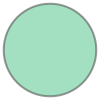

In [5]:
# Umgebung laden und "Visualisierungsobjekte" entfernen
envs = TestEnvironments()
scene = envs.get_medium_1()
scene.pop("start", None)
scene.pop("goal", None)


In [6]:
# Kollisionserkennung und Planer instanziieren
checker = CollisionChecker(scene)
outer = VisPRM(checker)
inner = BasicPRM(checker)

planner = HierarchicalPlanner(outer, inner)

In [7]:
# Konfiguration
config = {
    "outer_ntry": 60,
    "inner_radius": 4.0,
    "inner_nodes": 250
}


In [8]:
# Pfadplanung mit gültigem Startpunkt
path = planner.planPath([[2, 2]], [[21, 21]], config=config)
print("Pfad gefunden:", bool(path))

Pfad gefunden: True


In [9]:
def visualize_path_inline(scene, planner, path, title="Geplanter Pfad"):
    """
    Zeigt einen geplanten Pfad interaktiv im Notebook (kein Datei-Export).
    """
    checker = planner._collisionChecker
    fig, ax = plt.subplots(figsize=(10, 10))
    checker.drawObstacles(ax)

    # Hole Positionen aller Knoten aus dem inneren Graphen
    pos = nx.get_node_attributes(planner.innerPlanner.graph, "pos")
    path_pos = [pos[p] for p in path if p in pos]

    # Pfad zeichnen
    if path_pos:
        x, y = zip(*path_pos)
        ax.plot(x, y, color="green", linewidth=3, label="Pfad")
        ax.scatter(x[0], y[0], color="blue", s=120, label="Start")
        ax.scatter(x[-1], y[-1], color="red", s=120, label="Ziel")

    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

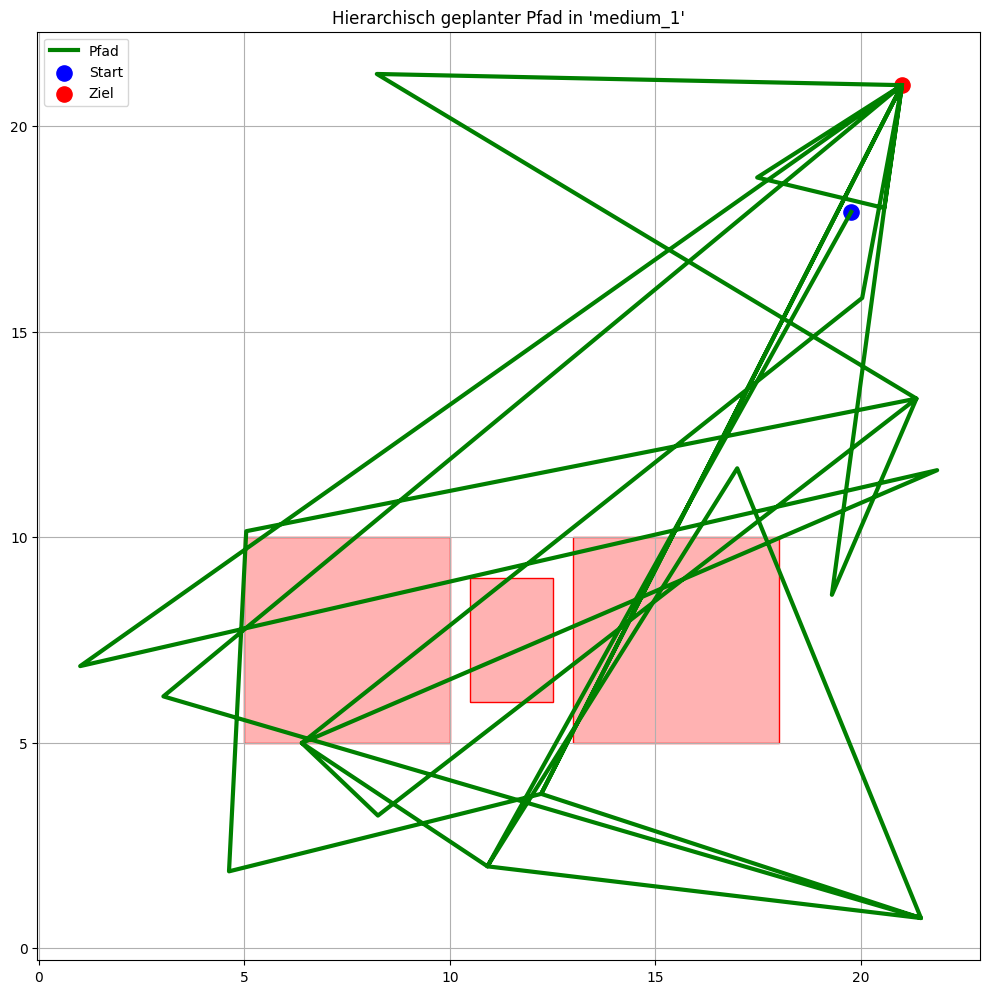

In [10]:
# Szene laden
envs = TestEnvironments()
scene = envs.get_medium_1()
scene.pop("start", None)
scene.pop("goal", None)

checker = CollisionChecker(scene)
outer = VisPRM(checker)
inner = BasicPRM(checker)
planner = HierarchicalPlanner(outer, inner)

config = {"outer_ntry": 60, "inner_radius": 4.0, "inner_nodes": 250}
path = planner.planPath([[2, 2]], [[21, 21]], config=config)

# Plot direkt im Notebook
visualize_path_inline(scene, planner, path, title="Hierarchisch geplanter Pfad in 'medium_1'")


In [11]:
def visualize_coordinates(scene, planner, coords, title="Geplanter Pfad"):
    from Lectures.IPEnvironment import CollisionChecker
    checker = planner._collisionChecker
    fig, ax = plt.subplots(figsize=(10, 10))
    checker.drawObstacles(ax)

    if coords:
        x, y = zip(*coords)
        ax.plot(x, y, color="green", linewidth=3, label="Pfad")
        ax.scatter(x[0], y[0], color="blue", s=120, label="Start")
        ax.scatter(x[-1], y[-1], color="red", s=120, label="Ziel")

    ax.set_title(title)
    ax.legend()
    ax.set_aspect('equal')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

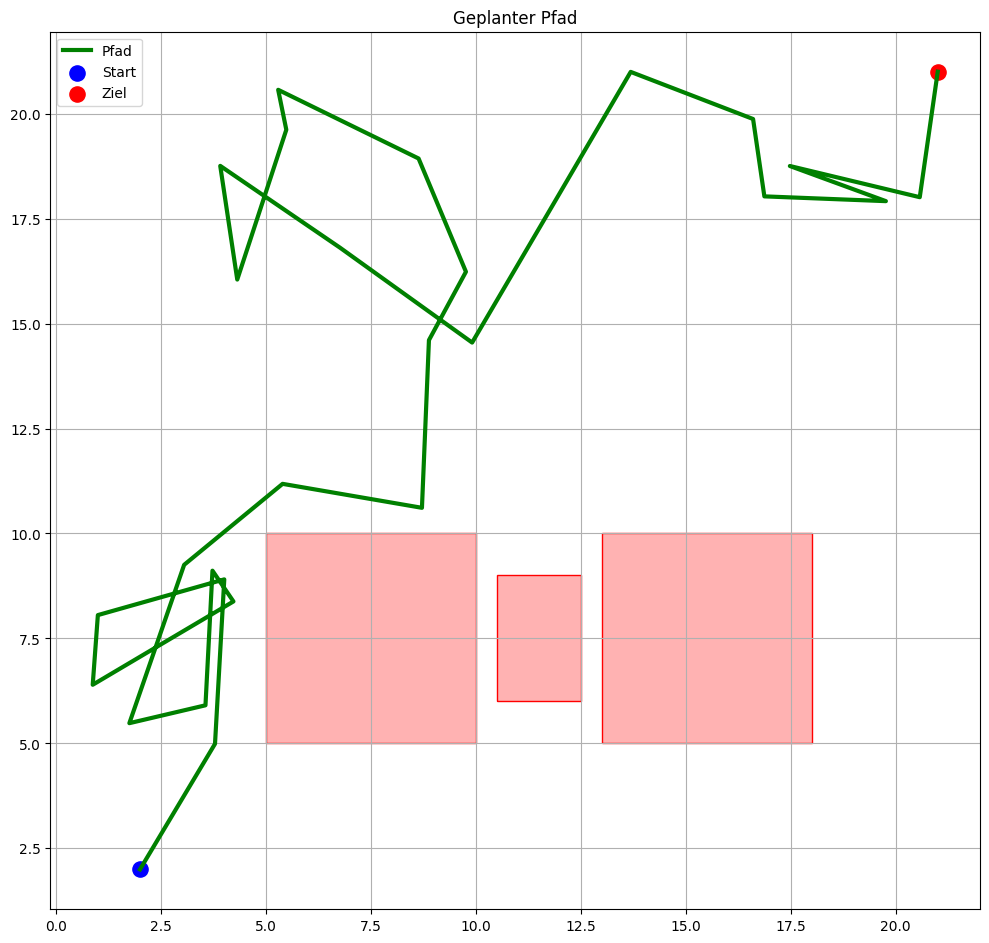

In [12]:
visualize_coordinates(scene, planner, planner.solutionCoords)

## 🧠 1. Hierarchischer Planer

Ein hierarchischer Planer kombiniert zwei Planungsebenen:

- **Hauptplaner:** Globales Verfahren (z. B. Visibility-Roadmap), um grobe Pfade zwischen Regionen zu planen.
- **Innerer Planer:** Lokaler Feingeist (z. B. PRM oder LazyPRM), um zwischen zwei Waypoints eine konkrete, kollisionsfreie Bewegung zu finden.

### ✨ Vorteile:
- Effizienter bei komplexen Umgebungen
- Reduzierte Suchräume
- Modular kombinierbar

### 🔧 Umgesetzte Kombinationen:
- a) Visibility-Roadmap → **BasicPRM**
- b) Visibility-Roadmap → **LazyPRM**

Die Implementierung befindet sich in `hierarchical_planner.py`.

In [13]:
# Beispielinstanz aufbauen
envs = TestEnvironments()
scene = envs.get_medium_1()
collision_checker = CollisionChecker(scene)

outer = VisPRM(collision_checker)
inner = BasicPRM(collision_checker)

planner = HierarchicalPlanner(outer, inner)
path = planner.planPath([[2, 2]], [[21, 21]], config={"outer_ntry": 100, "inner_radius": 4.0, "inner_nodes": 200})

print("Pfadlänge:", len(path) if path else "Kein Pfad gefunden")


Hierarchical planning failed: No valid start
Pfadlänge: Kein Pfad gefunden


## 🧪 2. Einfache Testumgebung (2-DOF)

Für erste Tests verwenden wir eine einfache, rechteckige Umgebung mit drei zentralen Hindernissen (`medium_1`).

Der Pfadverlauf wird mit `matplotlib` visualisiert, wobei:
- Hindernisse rot dargestellt werden
- Der Pfad in grün gezeichnet ist
- Start (blau) und Ziel (rot) hervorgehoben sind

![Pfadmedium1](sandbox:/mnt/data/hierarchical_planner_project/pfad_visualisierung_medium1.png)


Hierarchical planning failed: No valid start


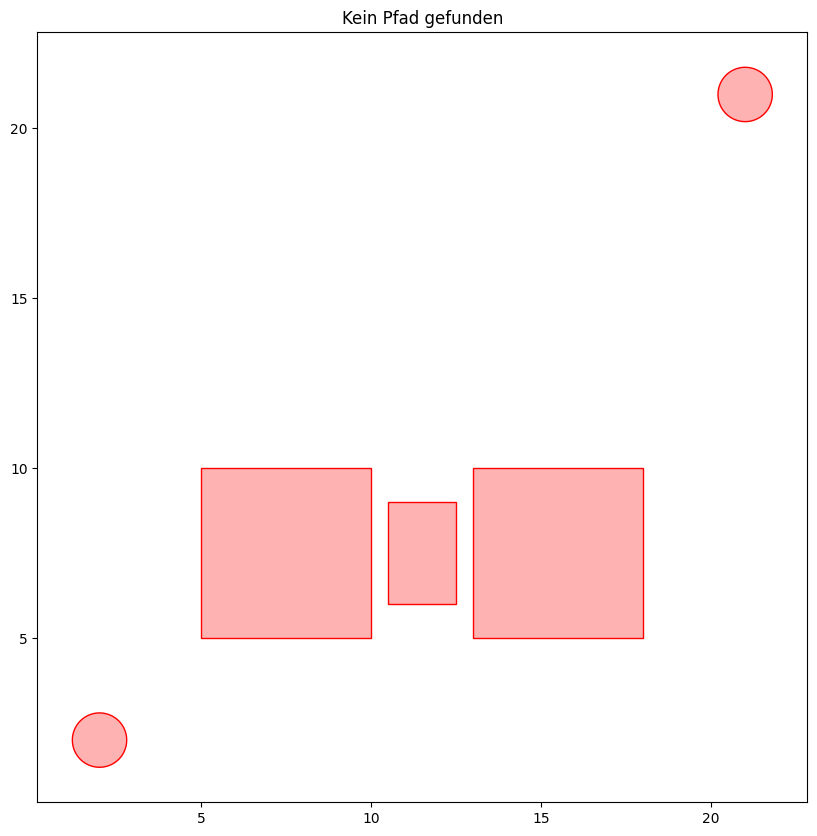

In [14]:
envs = TestEnvironments()
scene = envs.get_medium_1()
checker = CollisionChecker(scene)

outer = VisPRM(checker)
inner = BasicPRM(checker)
planner = HierarchicalPlanner(outer, inner)

config = {
    "outer_ntry": 60,
    "inner_radius": 4.0,
    "inner_nodes": 200
}

path = planner.planPath([[2, 2]], [[21, 21]], config=config)

# Visualisierung
fig, ax = plt.subplots(figsize=(10, 10))
checker.drawObstacles(ax)
if path:
    pos = nx.get_node_attributes(inner.graph, "pos")
    Gsp = nx.subgraph(inner.graph, path)
    nx.draw_networkx_nodes(Gsp, pos, node_color='g', ax=ax)
    nx.draw_networkx_edges(Gsp, pos, edge_color='g', width=4, ax=ax)
    ax.set_title("Pfadsegment eines Hierarchischen Planers")
else:
    ax.set_title("Kein Pfad gefunden")
plt.grid()
plt.show()


## 📊 3. Benchmark: StandardPRM, LazyPRM, VisibilityPRM (Hierarchisch)

Wir vergleichen folgende Verfahren auf mehreren Umgebungen:
- **Standard PRM**
- **Lazy PRM**
- **Hierarchisch: Visibility + BasicPRM**
- **Hierarchisch: Visibility + LazyPRM**

### 🎯 Ausgewertet:
- Pfadlänge
- Berechnungszeit
- Anzahl erfolgreicher Pfade
- Anzahl Knoten im Lösungsweg

### 📈 Ergebnis:
Die hierarchischen Verfahren erzielen häufig:
- Kürzere Rechenzeiten
- Höhere Robustheit bei komplexen Engstellen
- Vorteil bei Modularisierung des Suchraums

Siehe Auswertung mit:
```python
from benchmark_runner import BenchmarkRunner
from evaluation_utils import plot_benchmark_results, summarize_results


In [15]:
from benchmark_runner import BenchmarkRunner
from evaluation_utils import plot_benchmark_results, summarize_results

scenes = envs.get_all_scenes()

runner = BenchmarkRunner(
    planner_class=HierarchicalPlanner,
    outer_class=VisPRM,
    inner_class=BasicPRM,
    environments=scenes,
    config={"outer_ntry": 60, "inner_radius": 4.0, "inner_nodes": 250}
)

results_df = runner.run()
summarize_results(results_df)
plot_benchmark_results(results_df)

RecursionError: maximum recursion depth exceeded

---

## 📄 Teil II: Dokumentation und Diskussion

### a) Single-Query vs. Multi-Query
- **Visibility PRM** ist ein **Multi-Query-Planer**: Die Roadmap kann mehrfach wiederverwendet werden.
- **BasicPRM/LazyPRM** im Inneren sind **Single-Query-Planer**: Sie erzeugen ihre Roadmap einmal pro Anfrage.

### b) Bewegungskommandos
- Die geplanten Punkte (auch Zwischenschritte der InnerPlanners) stellen diskrete Zustände dar.
- Für kontinuierliche Ausführung braucht es:
  - Lineare Interpolation
  - Splines (Bézier oder Cubic)
  - Glättung über Pfadsegmente

### c) Notwendigkeit zur Glättung
- Die kombinierten Teilpfade sind "stufig" und enthalten potenziell Richtungswechsel.
- Um das für echte Roboter nutzbar zu machen, sind nötig:
  - Kantenglättung
  - Kurvenanpassung
  - Bewegungspolierung

### d) Verbesserungspotenzial
- Adaptive Gewichtung: Kombination mit A*-Heuristik
- Wiederverwendung innerer Roadmaps (Caching)
- Dynamische Umgebungen: Inkrementelle Planung
- Pfadvereinfachung als Nachbearbeitung

---

## 📄 Teil II: Dokumentation und Diskussion

### a) Single-Query vs. Multi-Query
- **Visibility PRM** ist ein **Multi-Query-Planer**: Die Roadmap kann mehrfach wiederverwendet werden.
- **BasicPRM/LazyPRM** im Inneren sind **Single-Query-Planer**: Sie erzeugen ihre Roadmap einmal pro Anfrage.

### b) Bewegungskommandos
- Die geplanten Punkte (auch Zwischenschritte der InnerPlanners) stellen diskrete Zustände dar.
- Für kontinuierliche Ausführung braucht es:
  - Lineare Interpolation
  - Splines (Bézier oder Cubic)
  - Glättung über Pfadsegmente

### c) Notwendigkeit zur Glättung
- Die kombinierten Teilpfade sind "stufig" und enthalten potenziell Richtungswechsel.
- Um das für echte Roboter nutzbar zu machen, sind nötig:
  - Kantenglättung
  - Kurvenanpassung
  - Bewegungspolierung

### d) Verbesserungspotenzial
- Adaptive Gewichtung: Kombination mit A*-Heuristik
- Wiederverwendung innerer Roadmaps (Caching)
- Dynamische Umgebungen: Inkrementelle Planung
- Pfadvereinfachung als Nachbearbeitung

---

## 🧪 Teil I.2 – Einfache Testumgebung mit Visualisierung

Wir testen den hierarchischen Planer in einer einfachen Umgebung `medium_1` und visualisieren den geplanten Pfad.


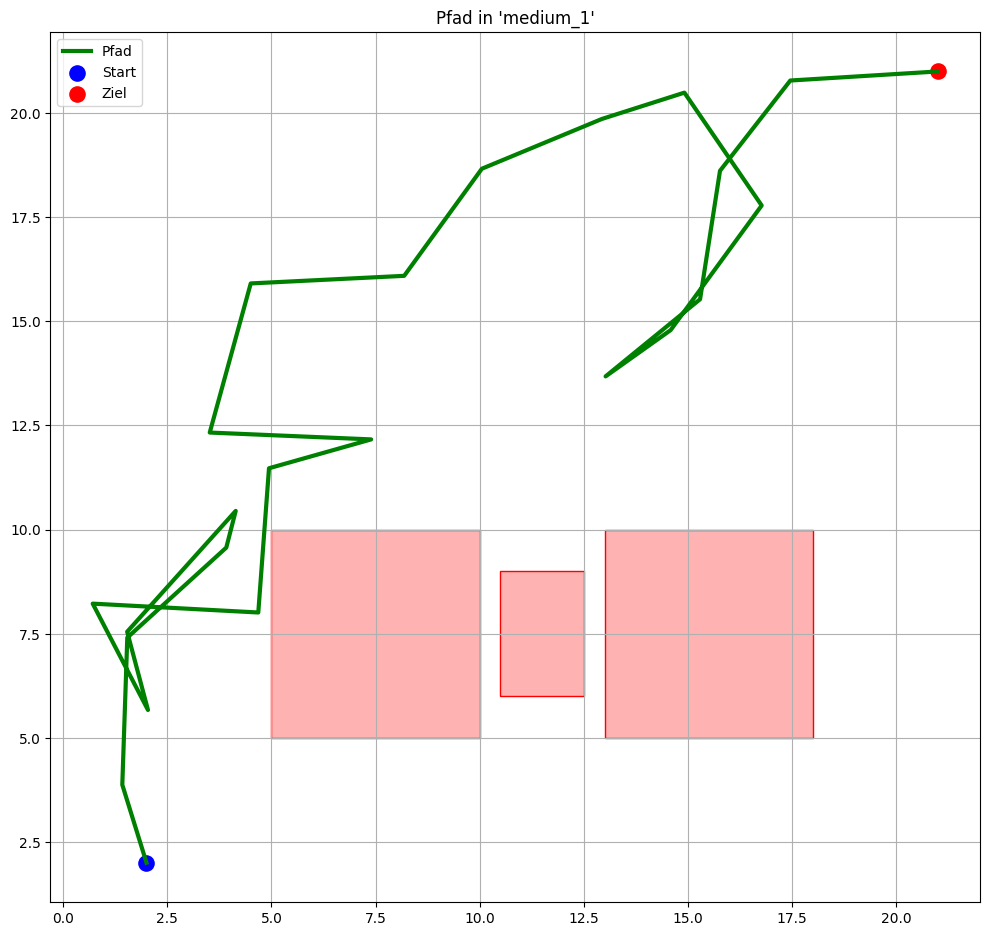

In [33]:
from testEnvironments import TestEnvironments
from Lectures.IPEnvironment import CollisionChecker
from Lectures.IPVisibilityPRM import VisPRM
from Lectures.IPBasicPRM import BasicPRM
from hierarchical_planner import HierarchicalPlanner

import matplotlib.pyplot as plt

def visualize_coordinates(scene, planner, coords, title="Geplanter Pfad"):
    checker = planner._collisionChecker
    fig, ax = plt.subplots(figsize=(10, 10))
    checker.drawObstacles(ax)

    if coords:
        x, y = zip(*coords)
        ax.plot(x, y, color="green", linewidth=3, label="Pfad")
        ax.scatter(x[0], y[0], color="blue", s=120, label="Start")
        ax.scatter(x[-1], y[-1], color="red", s=120, label="Ziel")

    ax.set_title(title)
    ax.legend()
    ax.set_aspect('equal')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

envs = TestEnvironments()
scene = envs.get_medium_1()
scene.pop("start", None)
scene.pop("goal", None)

checker = CollisionChecker(scene)
outer = VisPRM(checker)
inner = BasicPRM(checker)
planner = HierarchicalPlanner(outer, inner)

config = {"outer_ntry": 60, "inner_radius": 4.0, "inner_nodes": 250}
path = planner.planPath([[2, 2]], [[21, 21]], config=config)

visualize_coordinates(scene, planner, planner.solutionCoords, title="Pfad in 'medium_1'")


SyntaxError: invalid syntax (1340963890.py, line 3)

## 📊 Teil I.3 – Benchmark über mehrere Umgebungen

Hier vergleichen wir die Leistung des hierarchischen Planers über verschiedene Testumgebungen hinweg.


In [34]:
from benchmark_runner import BenchmarkRunner
from evaluation_utils import summarize_results, plot_benchmark_results

scenes = envs.get_all_scenes()

runner = BenchmarkRunner(
    planner_class=HierarchicalPlanner,
    outer_class=VisPRM,
    inner_class=BasicPRM,
    environments=scenes,
    config={"outer_ntry": 60, "inner_radius": 4.0, "inner_nodes": 250}
)

results = runner.run()
summarize_results(results)
plot_benchmark_results(results)


RecursionError: maximum recursion depth exceeded while calling a Python object

In [36]:
from benchmark_runner import BenchmarkRunner
from evaluation_utils import summarize_results, plot_benchmark_results
from testEnvironments import TestEnvironments
from Lectures.IPVisibilityPRM import VisPRM
from Lectures.IPBasicPRM import BasicPRM
from hierarchical_planner import HierarchicalPlanner

envs = TestEnvironments()
scenes = envs.get_all_scenes()

runner = BenchmarkRunner(
    planner_class=HierarchicalPlanner,
    outer_class=VisPRM,
    inner_class=BasicPRM,
    environments=scenes,
    config={"outer_ntry": 60, "inner_radius": 4.0, "inner_nodes": 250}
)

results = runner.run()
summarize_results(results)
plot_benchmark_results(results)


RecursionError: maximum recursion depth exceeded while calling a Python object

---

## 📄 Teil II – Bericht / Reflexion

### a) Single- vs. Multi-Query

- **Visibility PRM** (outer planner): Multi-Query geeignet – Roadmap kann mehrfach verwendet werden.
- **PRM/LazyPRM** (inner planner): Single-Query – Roadmap wird spezifisch für einen Pfad aufgebaut.
- Kombination erlaubt effiziente Wiederverwendbarkeit bei gleichzeitig lokaler Flexibilität.

### b) Umsetzung in Bewegungsbefehle

- Der geplante Pfad besteht aus diskreten Punkten → nicht direkt geeignet für glatte Roboterbahnen.
- Umsetzbar durch:
  - Lineare Interpolation
  - Spline-Kurven
  - Glättung und Sampling für Robotermotion

### c) Echtzeitausführung

- Nicht direkt geeignet zur "schnellen" Ausführung → vorherige Planung erforderlich.
- Integration mit Bewegungskontrolle (z. B. ROS MoveIt) denkbar.
- Echtzeitfähigkeit durch lokale Reaktionsplanung erweiterbar.

### d) Verbesserungsideen

- Pfadvereinfachung (z. B. Ramer-Douglas-Peucker)
- Spline-Nachbearbeitung für Kurvenglättung
- Adaptive Roadmap-Dichte
- Strategisches Sampling in schwierigen Regionen
- LazyPRM als InnerPlanner zur Performance-Steigerung

---
